# Решение задачи классификации: превышает ли значение CC50 медианное значение выборки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx', index_col=0)
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,...,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# подготовка данных
mediana = df['CC50, mM'].median()
print(f"Медиана CC50: {mediana:.4f}")

X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)
# констатные признаки
const_features = [col for col in df.columns if df[col].std() == 0]
X = X.drop(const_features, axis=1)
# Пропуски заполняем медианой
X = X.fillna(X.median())

# Бинарная классификация: 0 - CC50 ≤ медианы, 1 - CC50 > медианы
y = (df['CC50, mM'] > mediana).astype(int)

Медиана CC50: 411.0393


In [ ]:
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,...,fr_Nhpyrrole,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azo,fr_benzene,fr_bicyclic,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_ketone,fr_ketone_Topliss,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,0.000000,0.000000,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,10.633577,0.000000,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,8.966062,0.000000,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0
3,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,0.000000,0.000000,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,0.000000,0.000000,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
y

,"CC50, mM"
0,0
1,0
2,0
3,0
4,0
...,...
996,0
997,0
998,0
999,0


In [ ]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Размеры")
print(f"обучающая выборка: {X_train.shape}")
print(f"тестовая выборка: {X_test.shape}")

Размеры
обучающая выборка: (800, 192)
тестовая выборка: (201, 192)


In [ ]:
# Выводим распределение классов
y_train.value_counts(normalize=True)

,proportion
"CC50, mM",
0,0.5075
1,0.4925


Сильного дисбаланса классов нет


In [ ]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42))
]

In [ ]:
results = []  # Будет содержать словари с метриками для каждой модели
names = []

for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # accuracy
    accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=3,
                                      scoring='accuracy', n_jobs=-1)

    # f1-score
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=3,
                                scoring='f1', n_jobs=-1)

    # ROC-AUC
    roc_auc_scores = cross_val_score(pipeline, X_train, y_train, cv=3,
                                     scoring='roc_auc', n_jobs=-1)

    # Сохраняем результаты
    model_results = {
        'name': name,
        'accuracy_scores': accuracy_scores,
        'accuracy_mean': accuracy_scores.mean(),
        'accuracy_std': accuracy_scores.std(),
        'f1_scores': f1_scores,
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std(),
        'rocauc_scores': roc_auc_scores,
        'rocauc_mean': roc_auc_scores.mean(),
        'rocauc_std': roc_auc_scores.std(),
    }

    results.append(model_results)
    names.append(name)

    # Выводим результаты
    print(f"{name}:")
    print(f"  Accuracy: Среднее = {accuracy_scores.mean():.4f}, STD = {accuracy_scores.std():.4f}")
    print(f"  F1: Среднее = {f1_scores.mean():.4f}, STD = {f1_scores.std():.4f}")
    print(f"  ROC-AUC: Среднее = {roc_auc_scores.mean():.4f}, STD = {roc_auc_scores.std():.4f}")
    print("-" * 50)

Logistic Regression:
  Accuracy: Среднее = 0.7300, STD = 0.0079
  F1: Среднее = 0.7313, STD = 0.0053
  ROC-AUC: Среднее = 0.8147, STD = 0.0216
--------------------------------------------------
Random Forest:
  Accuracy: Среднее = 0.7425, STD = 0.0300
  F1: Среднее = 0.7411, STD = 0.0314
  ROC-AUC: Среднее = 0.8205, STD = 0.0235
--------------------------------------------------
XGBoost:
  Accuracy: Среднее = 0.7400, STD = 0.0214
  F1: Среднее = 0.7376, STD = 0.0179
  ROC-AUC: Среднее = 0.8101, STD = 0.0300
--------------------------------------------------
LightGBM:
  Accuracy: Среднее = 0.7313, STD = 0.0242
  F1: Среднее = 0.7294, STD = 0.0262
  ROC-AUC: Среднее = 0.8134, STD = 0.0334
--------------------------------------------------


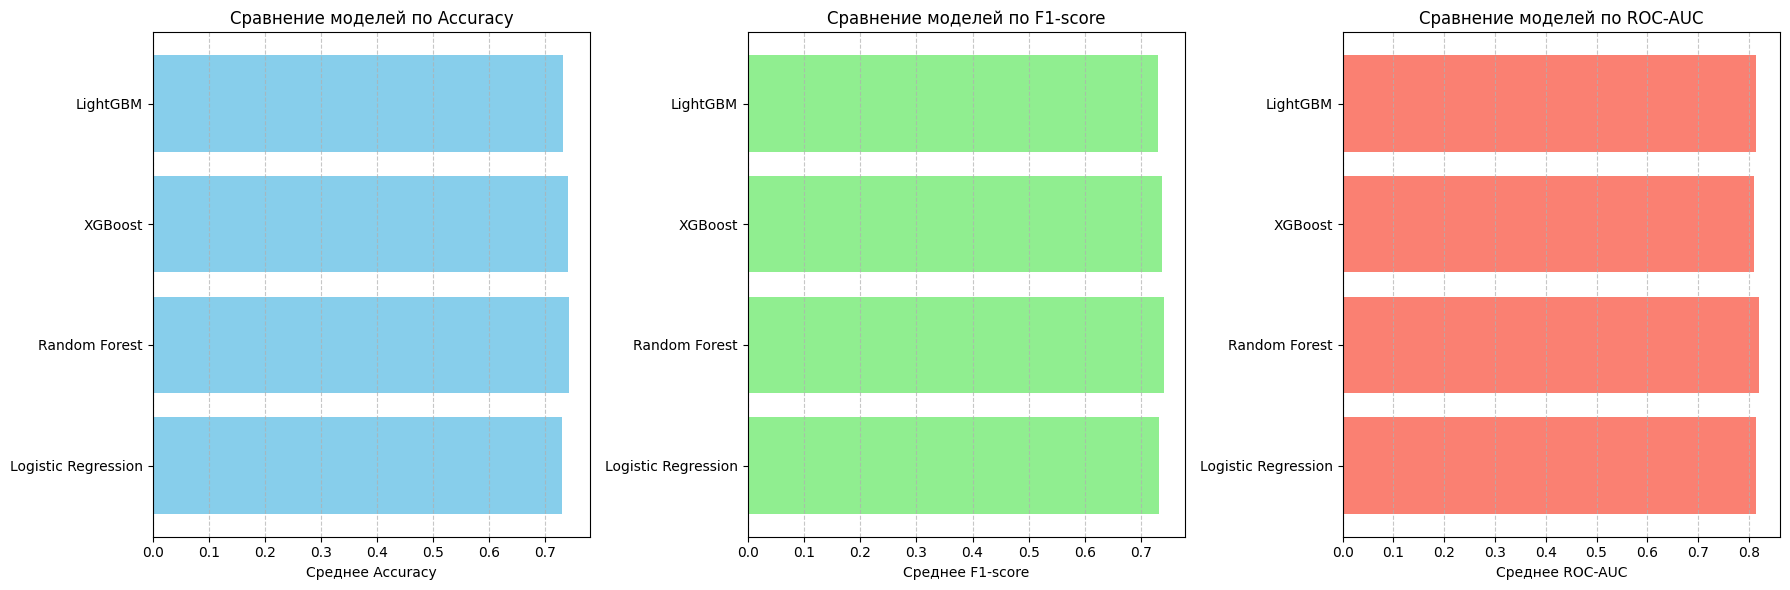

In [ ]:
accuracy_means = [res['accuracy_mean'] for res in results]
f1_means = [res['f1_mean'] for res in results]
roc_auc_means = [res['rocauc_mean'] for res in results]
names = [res['name'] for res in results]

plt.figure(figsize=(18, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.barh(names, accuracy_means, color='skyblue')
plt.title('Сравнение моделей по Accuracy')
plt.xlabel('Среднее Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# F1-score
plt.subplot(1, 3, 2)
plt.barh(names, f1_means, color='lightgreen')
plt.title('Сравнение моделей по F1-score')
plt.xlabel('Среднее F1-score')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# ROC-AUC
plt.subplot(1, 3, 3)
plt.barh(names, roc_auc_means, color='salmon')
plt.title('Сравнение моделей по ROC-AUC')
plt.xlabel('Среднее ROC-AUC')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Наилучшие результаты у XGBoost и Случайного леса

In [ ]:
# Подбор гиперпараметров для случайного леса

param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 10, None],
    'model__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_rf.best_params_)
print("Лучший ROC-AUC:", grid_rf.best_score_)

Лучшие гиперпараметры: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Лучший ROC-AUC: 0.8278752365914966


In [ ]:
# Подбор гиперпараметров для XGBoost
param_grid_xgb = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5, 10],
    'model__learning_rate': [0.01, 0.1]
}

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42))
])

grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_xgb.best_params_)
print("Лучший ROC-AUC:", grid_xgb.best_score_)

Лучшие гиперпараметры: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50}
Лучший ROC-AUC: 0.8169178125568987


In [ ]:
# лучшая модель случайного леса
best_model = grid_rf.best_estimator_

# Предсказания на тестовых данных
y_pred = best_model.predict(X_test)
# Вероятности для ROC-AUC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Оценка качества
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Оценки метрик на тестовых данных:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Оценки метрик на тестовых данных:
Accuracy: 0.7910
F1: 0.7879
ROC-AUC: 0.8891


Text(45.72222222222221, 0.5, 'Истинный класс')

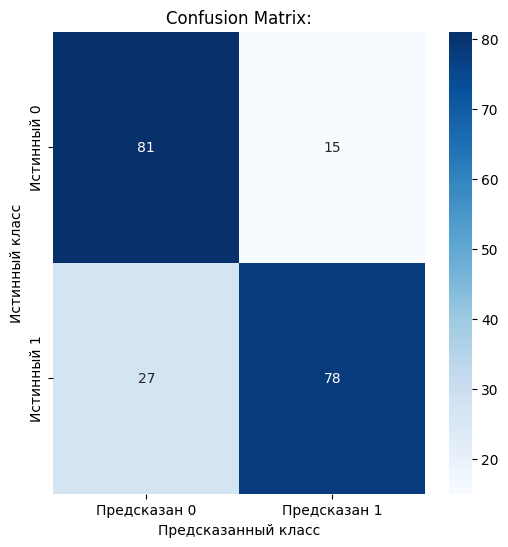

In [ ]:
# confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предсказан 0', 'Предсказан 1'],
            yticklabels=['Истинный 0', 'Истинный 1'])
plt.title(f'Confusion Matrix:')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

In [ ]:
print(classification_report(y_test, y_pred, target_names=['CC50 ≤ медианы', 'CC50 > медианы'], digits=3))

                precision    recall  f1-score   support

CC50 ≤ медианы      0.750     0.844     0.794        96
CC50 > медианы      0.839     0.743     0.788       105

      accuracy                          0.791       201
     macro avg      0.794     0.793     0.791       201
  weighted avg      0.796     0.791     0.791       201



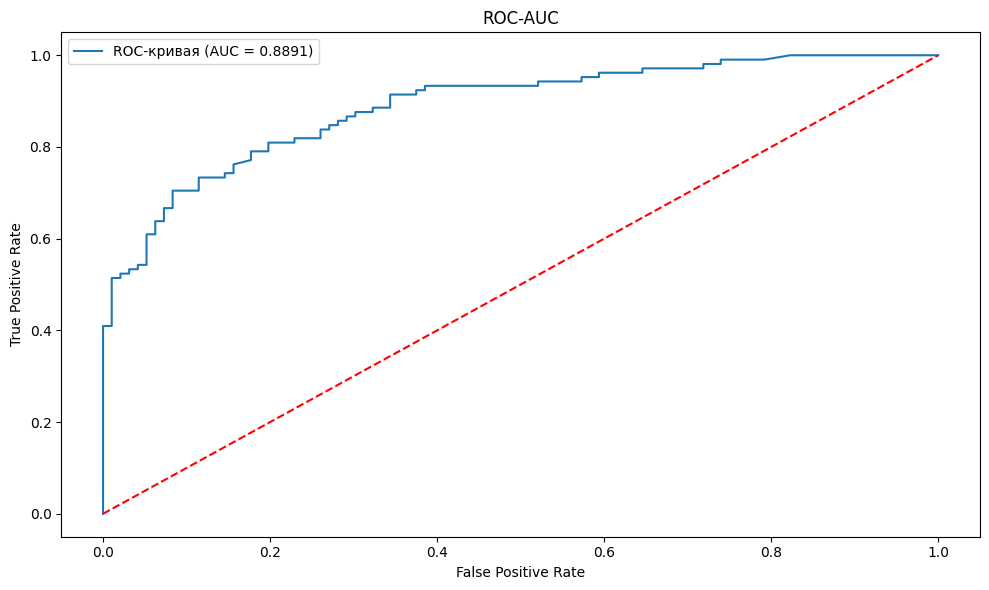

In [ ]:
# график ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend()
plt.tight_layout()

                 feature  importance
104            NHOHCount    0.029305
57             PEOE_VSA7    0.023566
96           VSA_EState4    0.018630
65              SMR_VSA5    0.018621
18          BCUT2D_MWLOW    0.017259
11      MinPartialCharge    0.015572
24          BCUT2D_MRLOW    0.014724
20          BCUT2D_CHGLO    0.014425
12   MaxAbsPartialCharge    0.014331
5                    SPS    0.013162


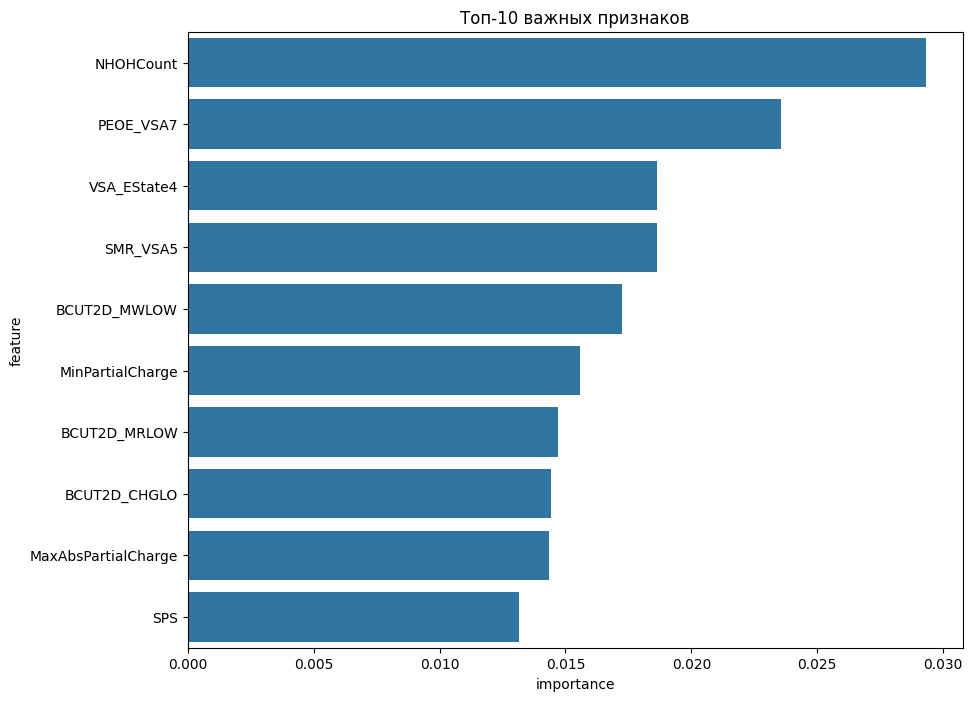

In [ ]:
# Важность признаков лучшей модели
feature_importance = best_model.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(feature_importance_df[:10])
# Топ 10 важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Топ-10 важных признаков')
plt.show()

## Выводы

Наилучшая модель - случайный лес с параметрами
- max_depth: 10,
- min_samples_split: 5,
- n_estimators: 100

Оценки метрик на тестовых данных:    
Accuracy: 0.7910  
F1: 0.7879  
ROC-AUC: 0.8891   

Модель показала хорошую способность различать классы

Наиболее важные признаки для решения задачи классификации CC50:   
- NHOHCount  
- PEOE_VSA7  
- VSA_EState4  
- SMR_VSA5   
- BCUT2D_MWLOW  
- MinPartialCharge  
- BCUT2D_MRLOW   
- BCUT2D_CHGLO  
- MaxAbsPartialCharge
-  SPS

Рекоммендаци по улучшению:
- Более глубокий EDA
- Более тщательный подбор гиперпараметров моделей
- применить Feature Engineering для создания новых признаков